In [1]:
import numpy as np
import pandas as pd

from collections import OrderedDict
from sklearn.model_selection import train_test_split

import readline 
import rpy2.rinterface
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
pandas2ri.activate()

from CausalTree import *
from auxiliary import *
%run ./datasets/simulate_treatment_data.py


%load_ext rpy2.ipython

## The Algorithm in Action 

In this section we put our Causal Tree implementation to the test. At first we consider a basic data set containing 2 covariates. Then we use the more complex data set used in the project folder **Simulation Study** to benchmark the prediction capabilities of our implementation against *OLS*, *KNN* and the official *Generalized Random Forest* Package. 

### Simple Data Generating Process 

Figure 3 displays the conditional treatment effect function. Here the x1-x2-Plane is simply split into its four quadrants. In the first quadrant the treatment effect is given by 0, in the second by 2, 14 in the third and at last -5 in the fourth quadrant. Next we simulate data on the given DGP and fit our Causal Tree implementation to it using its K-Fold cross validation pruning method. 

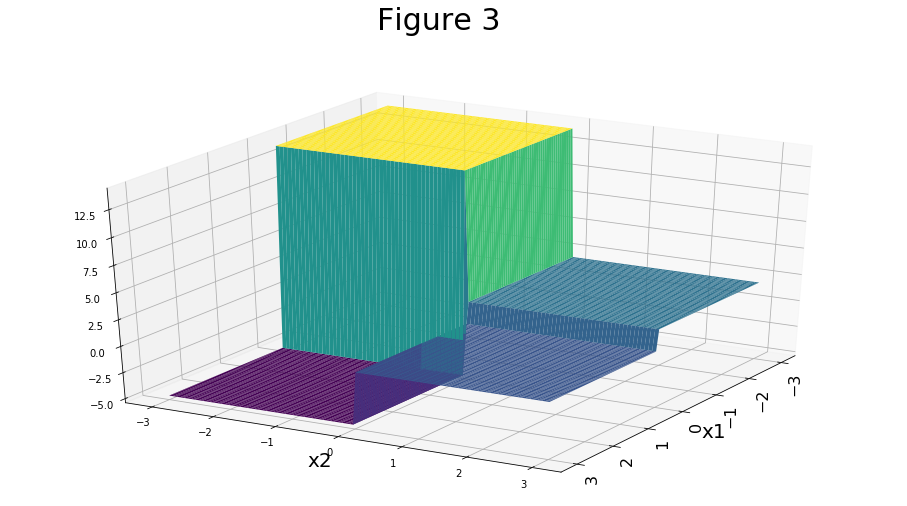

In [45]:
plot_figure3(width=16, height=8, view_x = 30, view_y=30)

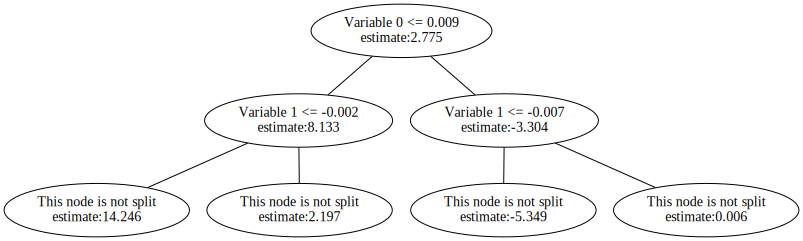

In [50]:
X, y, D = simulate_treatment_data(agents=500, noise=True)  # with noise set to True we add an error term to each observation 

tree_sparse, tree_opt = CausalTree.apply_kFold_CV(X, y, D, k=5, thresh=0, sparsity_bias=.5)

tree_sparse.plot()

We observe that in this simple example the Causal Tree works exactly as expected and splits the plane into the four regions. On top of that its predictions in each quadrant are also very close to the true parameters. 

### Data Generating Process From Simulation Study 

In this subsection we consider the more involved data generating process presented, in more detail, in the folder **Simulation Study**. The conditional treatment effect function is displayed in figure 4. In comparison to the function above, the function in figure 4 is smooth and can therefore never be completely estimated by trees in finite samples. However, we see that there are many flat regions. We would hope to see that the Causal Tree splits the $x_1$ and $x_2$ axis at roughly 1/3 and estimates 0, 2 and 4.

Below we simulate the data using an R script, which also computes the estimates for KNN and OLS, as well as the generalized random forest (grf). Since the folder **Simulation Study** contains a complete monte-carlo-simulation, we will only consider a single draw as to check if the Causal Tree implementation can match up to the grf package. 

Here we draw from $n=1000$ agents and use $K=20$ covariates from which only the first two are relevant. We expect to see that the 18 irrelevant covariates are not considered in the splits. In particular we expect the tree to split at $x_i = \frac{1}3$ for a fixed $i \in \{1, 2\}$ and then in each of the resulting regions split again at $x_j = \frac{1}3$ for $j \in \{1, 2\}$ but $j \neq i$.

For some unknown reason we experienced weird behavior of the Causal Tree pruning algorithm with this particular data set. That is why we will use only the standard fitting function on the given data set and then cut off all nodes that are located at a level deeper than two, since theoretically we expect that the data set can be optimally partitioned with two cuts. By simply cutting off all deep layers we essentially force the tree model to be sparser. We will see that in the current setting this approach makes the Causal Tree perform almost as good as the grf. Unfortunately in a real world scenario we would not know at which layer to cut; however, since ultimately we are interested in Causal Forest algorithms (see reference below as well as last subsection), which do *not* rely on the pruning process, this problem might *not* be of interest, as long as it actually stems from the pruning process. 

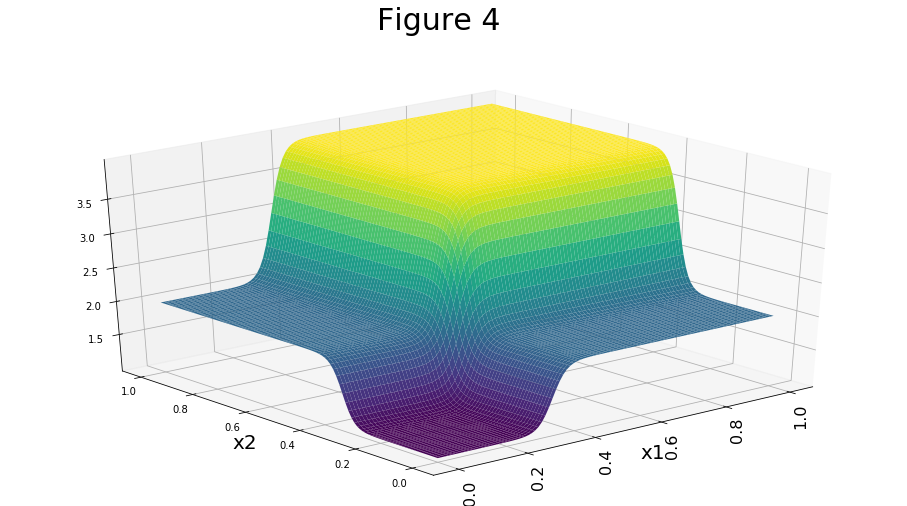

In [58]:
plot_figure4(width=16, height=8, view_x = 30, view_y=230, smoothness=50)

In [59]:
%%R
# read in necessary packages
pack <- c("tidyverse","plyr", "dplyr", "FNN", "modelr", "rpart", "doParallel", "grf")
invisible(suppressMessages(suppressWarnings(lapply(pack, require, character.only = TRUE))))

# load relevant functions
source("datasets/simAW.R")

# set parameter values
n  <- 1000 # number of observations
K  <- 20 # number of covariates 
kC <- 20 # number of nearest neighbors (for knn) 

# simulate data 
r_df <- simAW(n, kC, K, sd=sqrt(.5), smoothness=50)

train_ind  <- sample(seq_len(n), size = floor(.7 * n))
r_df_train <- r_df[train_ind, ]
r_df_test  <- r_df[-train_ind, ]

# compute cate using grf
allX <- grep("^[X]", names(r_df_train), value = TRUE)
cf <- grf::causal_forest(X = as.matrix(r_df_train[, allX]), 
                         Y = as.matrix(r_df_train$Y_obs),
                         W = as.matrix(r_df_train$D),
                         num.trees = 100,
                         num.threads = 1,
                         honesty = FALSE)
        
cf_pred <- predict(cf, as.matrix(r_df_test[, allX]))  # predictions of causal forest on testing data
cf_mse <- sum((r_df_test$CATE- cf_pred)^2) / nrow(r_df_test) # mean squared error of causal forest on testing data 

In [60]:
r_df_train = ro.r('r_df_train')
r_df_test = ro.r('r_df_test')
r_mse_grf = ro.r('cf_mse')
K = ro.r('K')
with localconverter(ro.default_converter + pandas2ri.converter):
    df_train = ro.conversion.rpy2py(r_df_train)
    df_test = ro.conversion.rpy2py(r_df_test)
    mse_grf = ro.conversion.rpy2py(r_mse_grf)
    K = int(ro.conversion.rpy2py(K))

df_train.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,I19,I20,D,Y0,Y1,Y_obs,tauhatknn,vartauhatknn,Cate_ols,CATE
1,0.955437,0.512708,0.032844,0.545923,0.900330,0.427940,0.818300,0.872999,0.799762,0.107697,...,0.000000,0.000000,0,-2.523864,2.228128,-2.523864,3.333173,0.014106,3.527889,3.999745
2,0.856509,0.768860,0.877378,0.884645,0.295024,0.784730,0.581852,0.426120,0.501521,0.227068,...,0.765545,0.289588,1,-1.572091,2.156151,2.156151,3.185885,0.014106,4.142155,4.000000
3,0.682290,0.593679,0.537580,0.065918,0.018586,0.208802,0.293601,0.782908,0.959926,0.414825,...,0.564436,0.884283,1,-2.677676,1.523214,1.523214,2.745116,0.014106,3.369752,3.999996
4,0.234340,0.212143,0.627217,0.584238,0.633021,0.202192,0.905877,0.771290,0.917154,0.349354,...,0.857182,0.448140,1,-1.308980,1.274139,1.274139,2.112901,0.014106,1.432816,1.009383
5,0.842187,0.087058,0.486946,0.852534,0.931901,0.083383,0.307948,0.547621,0.466810,0.639549,...,0.637073,0.177004,1,-0.137745,-0.404142,-0.404142,2.529613,0.014106,2.592140,2.000009


In [61]:
X_test = df_test.iloc[:, 0:K].copy()

y_train = df_train['Y_obs'].copy()
X_train = df_train.iloc[:, 0:K].copy()
D_train = df_train['D'].copy()

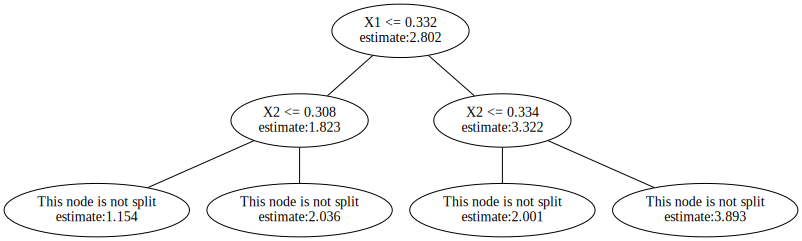

In [62]:
ctree = CausalTree()
ctree.fit(X_train, y_train, D_train)

node_list = CausalTree.get_level_in_list(ctree, 2)
for node in node_list:
    node.left_child = None
    node.right_child = None
    
ctree.plot()

In [26]:
tau_hat_causal_tree = ctree.predict(X_test)
tau_hat_knn = df_test['tauhatknn'].values
tau_hat_ols = df_test['Cate_ols'].values
tau_real = df_test['CATE'].values

tau_hat_dict = OrderedDict()
tau_hat_dict["knn"] = tau_hat_knn
tau_hat_dict["ols"] = tau_hat_ols,
tau_hat_dict["ctree"] = tau_hat_causal_tree

mse_dict = OrderedDict()
mse_dict['grf'] = float(mse_grf)

for key, value in tau_hat_dict.items():
    mse_dict[key] = ((tau_real - value) ** 2).mean()
    
mse_df = pd.DataFrame.from_dict(dict(mse_dict), orient='index')
mse_df.columns = ['mse']
mse_df

,mse
grf,0.175258
knn,0.534184
ols,0.456905
ctree,0.235352


As expected, the Causal Tree finds the correct splitting points, ignores the irrelevant covariates (at least in the first two splits) and estimates the conditional treatment effects fairly accurate. Furthermore, we see in the last table a comparison of achieved mean squared error on testing data of the methods KNN, OLS, GRF and Causal Tree. Here our Causal Tree algorithm implementation is clearly better than KNN and OLS and performs almost as good the generalized random forest package. 